<a href="https://colab.research.google.com/github/tashir0605/Cocepts-And-Practice/blob/main/LLM_from_Scratch/Dummy_GPT_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

In [52]:
import torch
import torch.nn as nn

In [53]:
from re import X
class DummyGPTModel(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.tok_emb =nn.Embedding(cfg["vocab_size"],cfg["emb_dim"])
        self.pos_emb= nn.Embedding(cfg["context_length"],cfg["emb_dim"])
        self.drop_emb=nn.Dropout(cfg["drop_rate"])

        self.trf_blocks=nn.Sequential(*[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm=DummyLayerNorm(cfg["emb_dim"])
        self.out_head =nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"],bias=False
        )

    def forward(self, in_idx):
      batch_size,seq_len=in_idx.shape
      tok_embeds=self.tok_emb(in_idx)
      pos_embeds=self.pos_emb(torch.arange(seq_len,device=in_idx.device))
      x=tok_embeds+pos_embeds
      x=self.drop_emb(x)
      x=self.trf_blocks(x)
      x=self.final_norm(x)
      logits =self.out_head(x)
      return logits

class DummyTransformerBlock(nn.Module):
  def __init__(self,cfg):
    super().__init__()



  def forward(self, x):

    return x

class DummyLayerNorm(nn.Module):
  def __init__(self,normalized_shape,eps=1e-5):
    super().__init__()


  def forward(self,x):

    return x

Tokenization

In [54]:
import tiktoken

tokenizer=tiktoken.get_encoding("gpt2")
batch=[]
txt1= "Every effort moves you"
txt2= "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
print(batch)
batch = torch.stack(batch,dim=0)
print(batch)

[tensor([6109, 3626, 6100,  345]), tensor([6109, 1110, 6622,  257])]
tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


*torch*.stack(batch, dim=0) takes the list of tensors in batch and stacks them into a single tensor along a new dimension (dim=0).

So:

Before: batch = [tensor1, tensor2] → a Python list of tensors.

After: batch = tensor([[...], [...]]) → one tensor with shape (2, seq_len) (like a mini-batch).



⚡ Basically: it converts a list of tokenized sentences into a batch tensor that PyTorch models can process together.

In [55]:
torch.manual_seed(123)
batch_example = torch.randn(2, 5) #A
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [56]:
mean=out.mean(dim=-1,keepdim=True)
print(mean)
var=out.var(dim=-1,keepdim=True)
print(var)

tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


In [57]:
out_norm=(out-mean)/torch.sqrt(var+1e-5)
mean=out_norm.mean(dim=-1,keepdim=True)
var=out_norm.var(dim=-1,keepdim=True)
print(out_norm)
print(mean)
print(var)

tensor([[ 0.6157,  1.4123, -0.8717,  0.5871, -0.8717, -0.8717],
        [-0.0189,  0.1121, -1.0875,  1.5171,  0.5647, -1.0875]],
       grad_fn=<DivBackward0>)
tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
tensor([[0.9996],
        [0.9997]], grad_fn=<VarBackward0>)


In [58]:
torch.set_printoptions(sci_mode=False)
print(mean)
print(var)

tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
tensor([[0.9996],
        [0.9997]], grad_fn=<VarBackward0>)


In [59]:
class LayerNorm(nn.Module):

  def __init__(self,emb_dim):
    super().__init__()
    self.eps=1e-5
    self.scale=nn.Parameter(torch.ones(emb_dim))
    self.shift=nn.Parameter(torch.zeros(emb_dim))

  def forward(self,x):
    mean=x.mean(dim=-1,keepdim=True)
    var=x.var(dim=-1,keepdim=True,unbiased=False)
    norm_x=(x-mean)/torch.sqrt(var+self.eps)
    return self.scale*norm_x +self.shift

why We take emb_dim as input parameter for the LayerNorm class:

Bcz hme scale and shift initiaze krne hai jo trainable parameters hai of the same dimension as embeddind dim.

You can see the return statement of forward jisme scale*norm_x kiya hai jo ek element wise multiplication hai.



In [60]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [61]:
class GELU(nn.Module):
  def __init__(self,):
    super().__init__()


  def forward(self,x):
    return 0.5*x*(1+torch.tanh(torch.sqrt(torch.tensor(2.0/torch.pi))*(x+0.044715*torch.pow(x,3))))

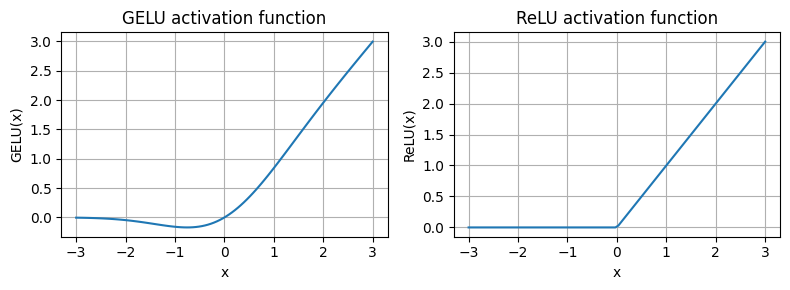

In [62]:

import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

# Some sample data
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()

In [63]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

In [64]:
class FeedForward(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.layers=nn.Sequential(
        nn.Linear(cfg["emb_dim"],4*cfg["emb_dim"]),
        GELU(),
        nn.Linear(4*cfg["emb_dim"],cfg["emb_dim"]),
        )

  def forward(self,x):
    return self.layers(x)

Shortcut Connection

In [65]:
import torch.nn as nn

class ExampleDeepNeuralNetwork(nn.Module):
  def __init__(self,layer_sizes,use_shortcut):
    super().__init__()
    self.use_shortcut=use_shortcut
    self.layers=nn.ModuleList([
        nn.Sequential(nn.Linear(layer_sizes[0],layer_sizes[1]),GELU()),
        nn.Sequential(nn.Linear(layer_sizes[1],layer_sizes[2]),GELU()),
        nn.Sequential(nn.Linear(layer_sizes[2],layer_sizes[3]),GELU()),
        nn.Sequential(nn.Linear(layer_sizes[3],layer_sizes[4]),GELU()),
        nn.Sequential(nn.Linear(layer_sizes[4],layer_sizes[5]),GELU()),
    ])


  def forward(self,x):
    for layer in self.layers:
        # Compute the output of the current layer
        layer_output=layer(x)

        if self.use_shortcut and x.shape ==layer_output.shape:
          x=x+layer_output
        else:
          x=layer_output

    return x

layer_sizes=[3,3,3,3,3,1]

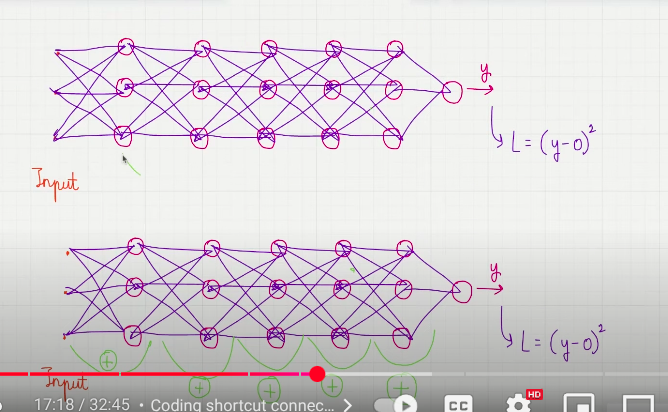

In [66]:
layer_sizes=[3,3,3,3,3,1]
sample_input=torch.tensor([[1.,0.,-1.]])
torch.manual_seed(123)
model_without_shortcut=ExampleDeepNeuralNetwork(layer_sizes,use_shortcut=False)
model_with_shortcut=ExampleDeepNeuralNetwork(layer_sizes,use_shortcut=False)

In [67]:
def print_gradients(model, x):
    # Forward pass
    output = model(x)
    target = torch.tensor([[0.]])

    # Calculate loss based on how close the target
    # and output are
    loss = nn.MSELoss()
    loss = loss(output, target)

    # Backward pass to calculate the gradients
    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            # Print the mean absolute gradient of the weights
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In [68]:
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173584925942123
layers.1.0.weight has gradient mean of 0.00012011159560643137
layers.2.0.weight has gradient mean of 0.0007152040489017963
layers.3.0.weight has gradient mean of 0.0013988736318424344
layers.4.0.weight has gradient mean of 0.005049645435065031


Try to understand the whole flow of the code:

Basically it all started from

**print_gradients(model_without_shortcut, sample_input)**

ab isme ye ho eha hai ki hum sample input i.e., [1,0,-1] pass kr rhe hai and hum ek object bhi paas kr rhe hai jo ki hai **model_without_shortcut**

ab ye jo hai iska object hai **"model_without_shortcut=ExampleDeepNeuralNetwork(layer_sizes,use_shortcut=False)"**

yahan se maine ye observe kiya ki when we have to define a object of a class then hme uss class ke input parameters wo daalna hota hai jo parameters constructor maang rha hai jaise ki **layer Size **, and **use_shortcut** hmne wo sample input nhi daala as a parameter in the class **ExampleDeepNeuralNetwork**
but after that when I was going throgh **print_grad function**

I observed these two lines

    output = model(x)


    target = torch.tensor([[0.]])

  in this, **model** is the object of **ExampleNeuralNetwork** in which we have passed  **x** but why here we are paasing x i.e., the sample_input, then I go throgh the **ExampleNeuralNetwork** again and I see one thing that is **forward** method of this class here it is requiring x as input, so fromt this route we are passing sample_input into the Neural Network.

  so maine ye deduce kiya ki if we have to pass any parameter that is required by the any method of the class then we will pass it as the parameter in object not in the Class parameter.

In [69]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
layer_sizes, use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169791162014008
layers.1.0.weight has gradient mean of 0.20694105327129364
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258540630340576


# TRANSFORMER BLOCK

In [70]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length - "Maximum number of token are allowed at a time to predict the next word"

    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of Transformer layers
    "drop_rate": 0.1,       # Dropout rate "On an average 10% of the neuron will be set to zero"
    "qkv_bias": False       # Query-Key-Value bias
}

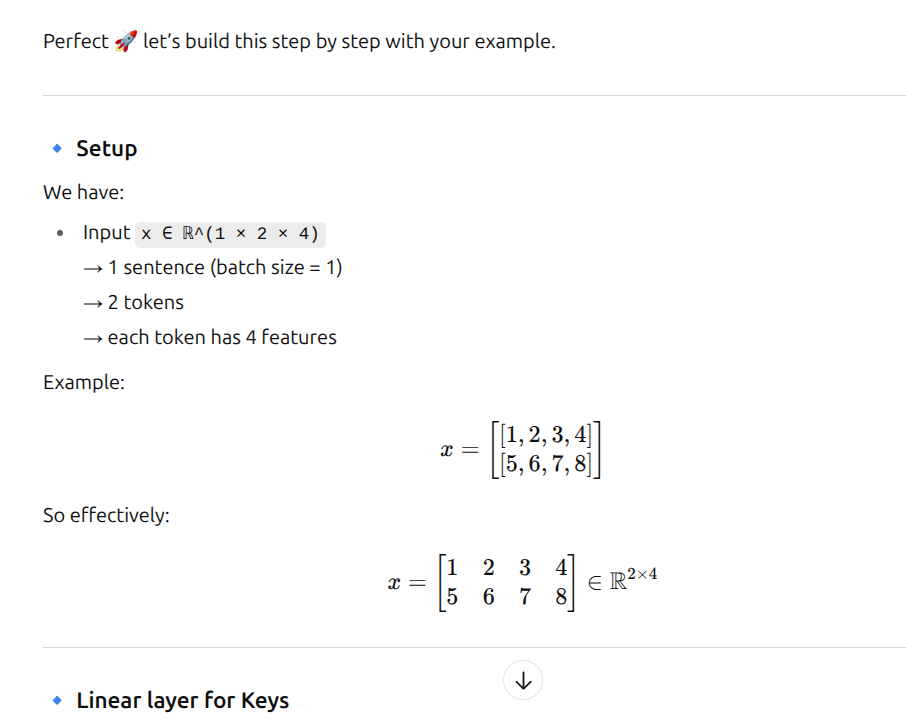

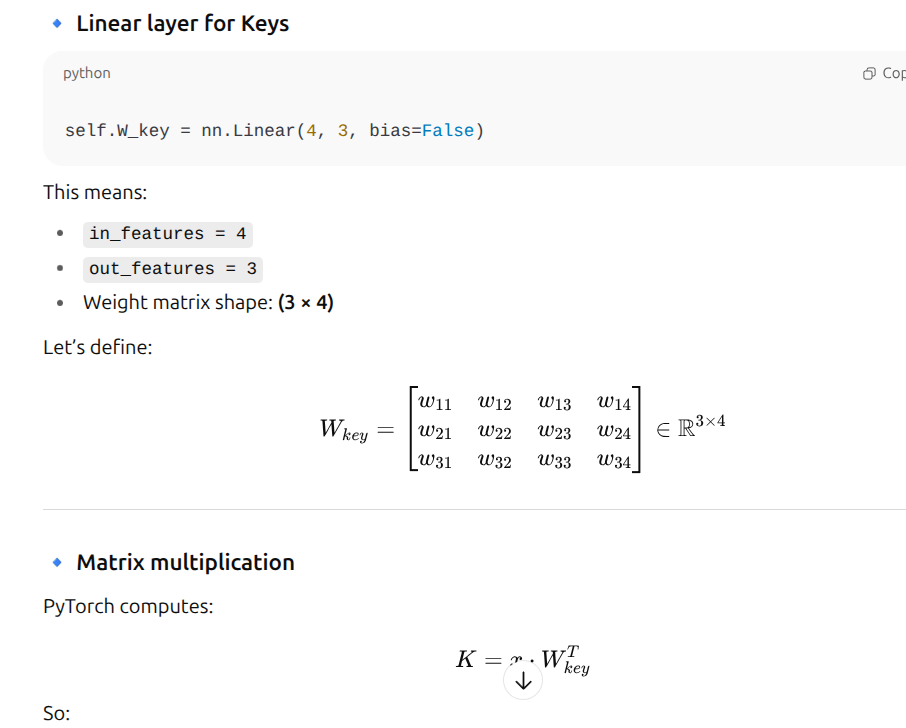

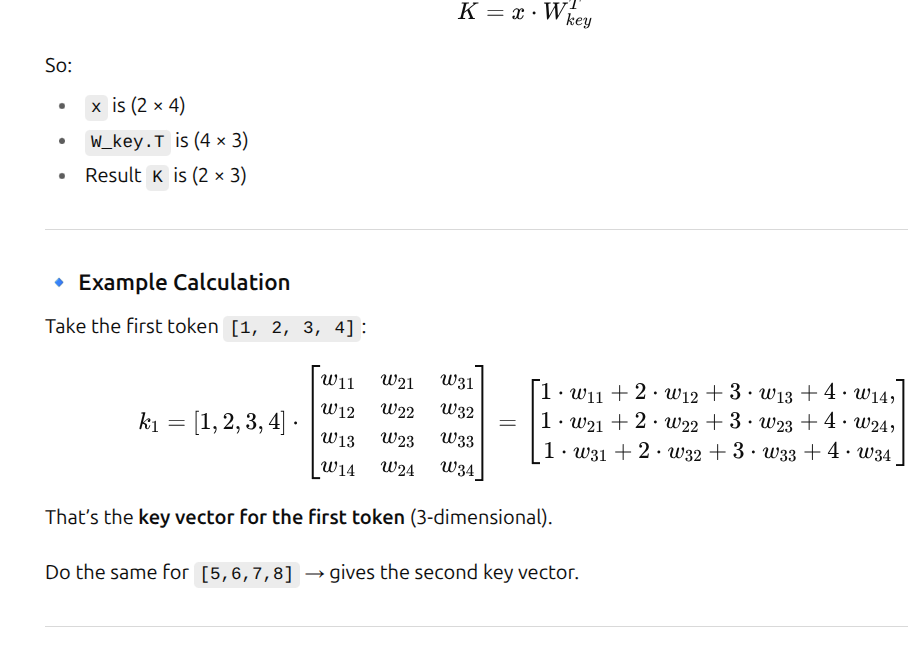

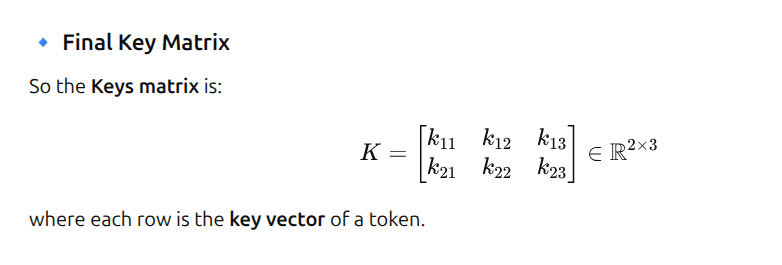

In [71]:
class CausalAttention(nn.Module):
  def __init__(self,d_in,d_out,dropout,context_length,qkv_bias=False):
    super().__init__()
    self.d_out=d_out
    self.W_query=nn.Linear(d_in,d_out,bias=qkv_bias)
    self.W_key=nn.Linear(d_in,d_out,bias=qkv_bias)
    self.W_value=nn.Linear(d_in,d_out,bias=qkv_bias)
    self.dropout=nn.Dropout(dropout)
    self.register_buffer("mask",torch.triu(torch.ones(context_length,context_length)))

  def forward(self,x):
    b,num_tokens,d_in=x.shape
    keys=self.W_key(x)
    queries=self.W_query(x)
    values=self.W_value(x)

    attn_scores=queries @ keys.transpose(1,2)
    attn_scores=attn_scores.masked_fill_(
        self.mask.bool()[:num_tokens,:num_tokens],-torch.inf)

    attn_weights=torch.softmax(attn_scores/keys.shape[-1]**0.5,dim=-1)

    attn_weights=self.dropout(attn_weights)

    context_vec=attn_weights@values

    return context_vec

In [72]:
torch.manual_seed(123)
context_length = batch.shape[1]
print(batch.shape[0])
ca = CausalAttention(GPT_CONFIG_124M["emb_dim"],GPT_CONFIG_124M["emb_dim"], GPT_CONFIG_124M["drop_rate"], context_length)

# Create a dummy input tensor with the expected shape (batch_size, num_tokens, emb_dim)
# This simulates the output of an embedding layer
print(GPT_CONFIG_124M["emb_dim"])
print(batch.shape[0])
dummy_input = torch.randn(batch.shape[0], context_length, GPT_CONFIG_124M["emb_dim"])
print(dummy_input)
print(dummy_input.shape)
context_vecs = ca(dummy_input)
print("context_vecs.shape:", context_vecs.shape)

2
768
2
tensor([[[-1.5632,  0.7050,  0.6753,  ...,  0.4357,  0.0887,  1.0272],
         [ 0.8931, -1.2902,  2.1305,  ...,  1.1242,  0.4051, -1.4932],
         [-0.4765,  1.3355, -0.3625,  ..., -0.9349,  0.0970, -0.4317],
         [-0.3253, -1.7321, -0.4791,  ..., -0.8521,  0.0812,  0.1004]],

        [[ 0.5539,  0.3545,  0.3798,  ..., -1.2831, -0.4684,  1.1287],
         [-0.0716,  0.1707, -0.4246,  ..., -0.5858,  0.2426, -1.1300],
         [-0.2828, -0.0136,  1.3186,  ..., -1.6329, -0.4608, -0.7776],
         [-0.3740, -1.2754,  0.7675,  ..., -0.0112, -0.5428,  0.7668]]])
torch.Size([2, 4, 768])
context_vecs.shape: torch.Size([2, 4, 768])


dummy_input tensor:

* batch.shape[0]: This represents the batch size. In this case, batch is the tensor created from tokenizing two sentences (txt1 and txt2), so batch.shape[0] is 2. This means we are processing two sequences of tokens simultaneously.


* context_length: This represents the maximum sequence length or the number of tokens in each sequence that the model can attend to. You defined context_length earlier as batch.shape[1], which is the number of tokens in the longest sequence in your batch (in this case, 4).


* GPT_CONFIG_124M["emb_dim"]: This represents the embedding dimension. It's the size of the vector used to represent each token after it has been passed through an embedding layer. In your GPT_CONFIG_124M dictionary, this is set to 768.


So, torch.randn(batch.shape[0], context_length, GPT_CONFIG_124M["emb_dim"]) creates a tensor of random numbers with the shape (batch_size, num_tokens, emb_dim), which is the expected shape for the input to the CausalAttention module after the token and positional embeddings have been applied.

In [73]:
class MultiHeadAttentionWrapper(nn.Module):
  def __init__(self,d_in,d_out,context_length,dropout,num_heads, qkv_bias=False):
    super().__init__()
    self.heads=nn.ModuleList(
        [CausalAttention(d_in,d_out,context_length,dropout,qkv_bias)
         for _ in range(num_heads)]
    )
  def forward(self,x):
    return torch.cat([head(x) for head in self.heads], dim=-1)

In [74]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

In [75]:
class TransformerBlock(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.att=MultiHeadAttention(
        d_in=cfg["emb_dim"],
        d_out=cfg["emb_dim"],
        context_length=cfg["context_length"],
        num_heads=cfg["n_heads"],
        dropout=cfg["drop_rate"],
        qkv_bias=cfg["qkv_bias"]

    )
    self.ff=FeedForward(cfg)
    self.norm1=LayerNorm(cfg["emb_dim"])
    self.norm2=LayerNorm(cfg["emb_dim"])
    self.drop_shortcut=nn.Dropout(cfg["drop_rate"])


  def forward(self,x):
    shortcut=x
    x=self.norm1(x)
    x=self.att(x)
    x=self.drop_shortcut(x)
    x=x+shortcut

    shortcut=x
    x=self.norm2(x)
    x=self.ff(x)
    x=self.drop_shortcut(x)
    x=x+shortcut
    return x

In [76]:
torch.manual_seed(123)
x = torch.rand(2, 4, 768) #A
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)
print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])
